In [389]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [390]:
########### 50 km/h
ll = 2

### 100%
fname = '/notebooks/images/test_fcn/final/_50/48.png'
IMAGE_SIZE_NEW = (32, 32)

### 50%
fname = '/notebooks/images/test_fcn/final/_50/68.png'
IMAGE_SIZE_NEW = (64, 64)

### 25%
fname = '/notebooks/images/test_fcn/final/_50/96.png'
IMAGE_SIZE_NEW = (128, 128)

### 15%
fname = '/notebooks/images/test_fcn/final/_50/124.png'
IMAGE_SIZE_NEW = (156, 156)

### 10%
fname = '/notebooks/images/test_fcn/final/_50/151.png'
IMAGE_SIZE_NEW = (184, 184)

In [391]:
################ priority_2
ll = 12

fname = '/notebooks/images/test_fcn/final/priority_2/priority_126x126_100%.jpg'
##IMAGE_SIZE_NEW = (126, 126)
IMAGE_SIZE_NEW = (32, 32)

fname = '/notebooks/images/test_fcn/final/priority_2/priority_176x176_50%.jpg'
##IMAGE_SIZE_NEW = (176, 176)
IMAGE_SIZE_NEW = (64, 64)

#fname = '/notebooks/images/test_fcn/final/priority_2/priority_252x252_25%.jpg'
##IMAGE_SIZE_NEW = (252,252)
#IMAGE_SIZE_NEW = (128, 128)

#fname = '/notebooks/images/test_fcn/final/priority_2/priority_326x326_15%.jpg'
##IMAGE_SIZE_NEW = (326, 326)
#IMAGE_SIZE_NEW = (156, 156)

#fname = '/notebooks/images/test_fcn/final/priority_2/priority_398x398_10%.jpg'
##IMAGE_SIZE_NEW = (398, 398)
#IMAGE_SIZE_NEW = (184, 184)

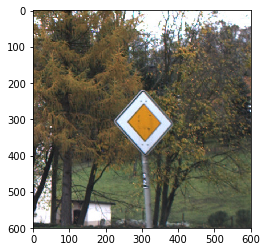

In [392]:
import sys
import scipy
import skimage
from skimage import io
from skimage import transform
from skimage.filters import gaussian

import tensorflow as tf
from keras.layers import Dense, Dropout, Flatten, merge
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
from keras.models import model_from_json
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

import my_mod_load as load
import my_mod_manipulate_image as manipulate
import numpy as np
import settings


from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.engine import InputLayer
import keras

import matplotlib.pyplot as plt


# load e normalizzazioen dell'immagine
img = io.imread(fname)
img = transform.resize(img, IMAGE_SIZE_NEW, order=3)
img_original = img

img = gaussian(img,.6,multichannel=True)*255
img = manipulate.normalize_img(img.astype(np.uint8))
img.shape = (1,) + img.shape

# print dell'immagine originale
plt.imshow(np.array(img_original.squeeze()))

In [393]:
#model = '/scripts/models/2018-04-14_1245/model_108-108-100_ep20'
model = '/notebooks/final_models/keras/2018-02-23_1203/model_108-108-100_ep40'

json_file = open("{}.json".format(model), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("{}.h5".format(model))

#loaded_model.summary()

In [394]:
new_model = Sequential()
input_layer = InputLayer(input_shape=(None, None, 1), name="input_new")
new_model.add(input_layer)

new_model.add(loaded_model.get_layer("conv2d_1"))
new_model.add(loaded_model.get_layer("conv2d_2"))
new_model.add(loaded_model.get_layer("max_pooling2d_1"))
#new_model.add(loaded_model.get_layer("dropout_1"))
new_model.add(loaded_model.get_layer("conv2d_3"))
new_model.add(loaded_model.get_layer("conv2d_4"))
new_model.add(loaded_model.get_layer("max_pooling2d_3"))
#new_model.add(loaded_model.get_layer("dropout_2"))

# first dense layer
flatten_layer = loaded_model.get_layer("flatten_1")
flatten_dim = flatten_layer.input_shape
print(flatten_dim)

dense_layer = loaded_model.get_layer("dense_1")
input_shape_dense = dense_layer.input_shape
print(input_shape_dense)
output_dim_dense =  dense_layer.get_weights()[1].shape[0]
print(output_dim_dense)
W, b = dense_layer.get_weights()
shape = (flatten_dim[1], flatten_dim[2], flatten_dim[3], output_dim_dense)
print(shape)
new_W = W.reshape(shape)
print("dimensioni nuovo kernel: ")
print(flatten_dim[1])
print(flatten_dim[2])
new_layer = Convolution2D(output_dim_dense,
                         (flatten_dim[1], flatten_dim[2]),
                         strides=(1, 1),
                         activation=dense_layer.activation,
                         padding='valid',
                         weights=[new_W, b],
                         name="conv2d_x1")
new_model.add(new_layer)

#new_model.add(loaded_model.get_layer("dropout_3"))

# second dense layer
dense_layer = loaded_model.get_layer("dense_2")
input_shape_dense = dense_layer.input_shape
print(input_shape_dense)
output_dim_dense =  dense_layer.get_weights()[1].shape[0]
print(output_dim_dense)
W, b = dense_layer.get_weights()
shape = (1, 1, input_shape_dense[1], output_dim_dense)
new_W = W.reshape(shape)
new_layer = Convolution2D(output_dim_dense,
                          (1, 1),
                          strides=(1, 1),
                          activation=dense_layer.activation,
                          padding='valid',
                          weights=[new_W, b],
                          name="conv2d_x2")
new_model.add(new_layer)

#print(new_model.summary())

(None, 5, 5, 108)
(None, 2700)
100
(5, 5, 108, 100)
dimensioni nuovo kernel: 
5
5
(None, 100)
43


In [395]:
predicted_proba = new_model.predict(img)
print("dimensione dell'otuput")
print(predicted_proba.shape)

dimensione dell'otuput
(1, 143, 143, 43)


In [396]:
import operator

#print("dimensione immagine originale x,y e dimensione output x,y")

#print(IMAGE_SIZE_NEW[0])
#print(IMAGE_SIZE_NEW[1])
#num_1 = predicted_proba.shape[1]
#num_2 = predicted_proba.shape[2]
#print(num_1)
#print(num_2)


sums = {}
my_max = 0
my_sum = 0
my_class = -1
for i in range(0, 43):
#    print(i)
    matrix = predicted_proba[:,:,:,i]
    my_sum = matrix.sum()
    sums[i] = my_sum
    #print("{}: {}".format(i, my_sum))
    if my_sum >= my_max:
        my_max = my_sum
        my_class = i       

sorted_x = sorted(sums.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_x)
print("risutato:")
print(my_max)
print(my_class)
print("right class:")
print(predicted_proba[:,:,:,ll].sum())


[(32, 7519.9355), (15, 6410.5151), (13, 2400.5752), (12, 1337.3741), (17, 350.28674), (42, 271.86017), (38, 242.39375), (33, 241.37834), (35, 187.19072), (20, 163.50699), (10, 152.12456), (34, 139.38159), (4, 120.53256), (26, 85.314102), (16, 74.56781), (8, 74.332436), (18, 65.968857), (22, 65.718613), (3, 64.997025), (1, 55.262169), (36, 52.299065), (5, 51.393929), (7, 42.952198), (11, 39.504276), (41, 38.088554), (9, 23.754234), (29, 23.459017), (39, 21.901653), (40, 19.036589), (6, 18.764521), (37, 17.670345), (14, 15.590287), (2, 11.330629), (25, 9.8175659), (30, 9.2693052), (0, 8.3251677), (28, 6.948566), (31, 6.6989722), (19, 4.0926113), (24, 1.7701482), (23, 1.6363952), (27, 1.3173289), (21, 0.16235825)]
risutato:
7519.94
32
right class:
1337.37


dimensione immagine originale x,y e dimensione output x,y
600
600
143
143
0.4 0.1 0.2 0.8 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.2 0.8 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.5 1.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0

0.6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.2 0.0 0.0 0.0 0.9 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.1 0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.7 0.6 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 
0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.8 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3 0.0 0.0 0.0 0.0 0.7 0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.1 0.7 0.1

0.0 0.0 0.0 0.6 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.5 0.9 1.0 0.8 0.0 0.0 0.2 0.8 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.6 0.2 0.0 0.0 0.2 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 1.0 0.6 0.5 0.1 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.9 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.3 0.0 0.0 0.0 
0.0 0.1 0.9 0.9 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.6 0.8 0.0 0.1 0.1 0.0 0.0 0.3 0.3 0.1 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.5 0.2 0.2 0.9 0.5 0.2

0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.7 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.6 0.9 0.6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.8 0.8 0.1 0.0 0.0 0.0 0.0 0.2 0.2 0.3 0.3 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.9 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3 0.1 0.1 0.1 0.0 0.0 0.0 0.0 0.0 0.7 1.0 0.0 0.1 0.0 0.0 0.0 0.0 0.1 0.2 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.4 0.1 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.6 0.3 0.1 0.9 0.2 0.4 0.3 0.2 0.0 0.0 0.0 0.0 0.1 
0.8 0.0 0.0 0.0 0.0 0.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.6 1.0 0.9 0.4 0.2 0.8 0.8 0.8 0.2 0.1 0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.6 0.0 0.1 0.9 1.0 1.0 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.1 0.1 0.8 0.6 0.2 0.0 0.0 0.0 0.6 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3 0.5 0.0

0.0 0.0 0.0 0.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.4 1.0 1.0 0.8 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.9 0.0 0.2 0.9 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3 0.9 0.2 0.1 0.1 0.2 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.6 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.6 0.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.7 1.0 0.9 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.9 0.9 0.4 0.3 0.8 1.0 0.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.8 1.0 1.0 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.1 0.0 0.0 0.0 0.2 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 1.0 0.1 0.1 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.3 0.1 0.0 0.0 0.0 0.0 0.4 0.7 0.0 0.0 
0.0 0.0 0.0 0.2 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.8 0.0 0.0 0.1 0.1 0.8 0.7 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 1.0 0.9 0.6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.7 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.1 0.0 0.1 0.5 1.0 0.4 0.3 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.1 0.0 0.0 0.0 0.0 1.0 1.0 0.9 0.0 0.0 0.0 0.0 0.0 0.0 0.3 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.6 0.4 0.3 0.0 0.0 0.8 0.9 0.7 0.6 0.6 0.2 0.0 0.0 0.1 0.0 0.1 0.7 0.1 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.4 0.8 0.1 0.1 0.9 1.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.3 0.0 0.0 0.0 0.0 0.0 0.6 1.0 1.0 0.8 0.0 0.0 0.0 0.0 0.0 0.3 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.2 0.1 0.1 0.1 0.3 0.0

0.0 0.0 0.0 0.2 0.9 0.4 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.7 0.1 0.2 0.8 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.7 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.6 0.0 0.0 0.0 0.5 0.3 0.0 0.0 0.0 0.5 0.8 0.3 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.5 0.9 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.4 0.1 0.3 0.7 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3 1.0 0.6 0.0 0.0 0.0 0.4 0.9 0.2 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.3 0.0 0.0 0.0

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.8 0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.5 0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.8 1.0 0.4 0.0 0.1 0.2 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.8 0.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.6 0.4 0.0 0.0 0.0 0.0 0.0 0.6 1.0 0.9 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.2 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.1 0.0 0.1 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

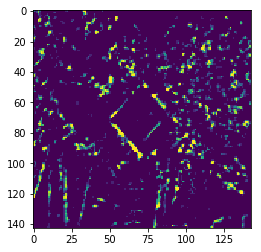

In [397]:
print("dimensione immagine originale x,y e dimensione output x,y")

print(IMAGE_SIZE_NEW[0])
print(IMAGE_SIZE_NEW[1])
num_1 = predicted_proba.shape[1]
num_2 = predicted_proba.shape[2]
print(num_1)
print(num_2)

original_matrix = [[0 for x in range(num_2)] for y in range(num_1)]
m = 0
for i in range(0, num_1):
    for j in range(0, num_2):
        #original_matrix[i][j] = i1
        prob = round(predicted_proba[0][i][j][ll], 1)
        original_matrix[i][j] = float("{0:.2f}".format(prob))
        #original_matrix[i][j] = round(prob, 3)
        
#        if prob > min_prob:
#            original_matrix[i][j] 
#        else:
#            original_matrix[i][j] = -255
#print(original_matrix)
original_matrix = np.array(original_matrix)
#original_matrix = np.ma.masked_where(original_matrix < 0, original_matrix)
plt.imshow(original_matrix)
#print(original_matrix)
#print(str(original_matrix)[1:-1])

for i in range(0, num_1):
    for j in range(0, num_2):
        print(original_matrix[i][j], end=" ")
    print()

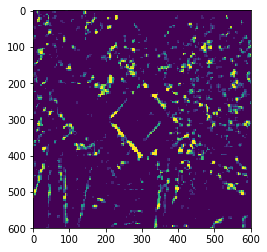

In [398]:
resized = scipy.ndimage.zoom(predicted_proba, (1,IMAGE_SIZE_NEW[0]/predicted_proba.shape[1],
                                               IMAGE_SIZE_NEW[1]/predicted_proba.shape[2], 1), order=0)

#print(predicted_proba)
#print(resized.shape[2])
num_1 = resized.shape[1]
num_2 = resized.shape[2]
new_matrix = [[0 for x in range(num_2)] for y in range(num_1)]
m = 0
for i in range(0, num_1):
    for j in range(0, num_2):
        #original_matrix[i][j] = i1
        prob = round(resized[0][i][j][ll], 1)
        new_matrix[i][j] = prob
#        if prob > min_prob:
#            original_matrix[i][j] 
#        else:
#            original_matrix[i][j] = -255
#print(original_matrix)
new_matrix = np.array(new_matrix)
#original_matrix = np.ma.masked_where(original_matrix < 0, original_matrix)
plt.imshow(new_matrix)
#print(new_matrix)

In [399]:
#from collections import Counter
#count = Counter(original_matrix)
#Counter({'a': 2, 'c': 2, 'b': 1, 'd': 1})
#count.most_common()
#print(original_matrix)

In [400]:
#new_matrix = np.array(new_matrix)
#new_matrix = (new_matrix/255)
#print(new_matrix[40])

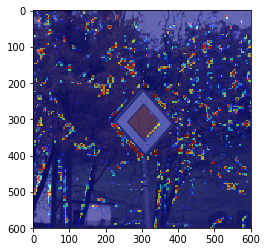

In [401]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Generate some data...
#gray_data = np.arange(10000).reshape(100, 100)

#masked_data = np.random.random(IMAGE_SIZE_NEW)

masked_data = np.ma.masked_where(new_matrix < -1, new_matrix)
#masked_data = np.dot(masked_data, 10)
# Overlay the two images
fig, ax = plt.subplots()
ax.imshow(img_original, cmap=cm.gray)
ax.imshow(masked_data, cmap=cm.jet, alpha=0.6)
plt.show()